## Spleen Model With NVIDIA Pretrain
- Uses Unet architecture
- Pretrained model at: https://ngc.nvidia.com/catalog/models/nvidia:med:clara_pt_spleen_ct_segmentation

##### Uncomment below to install all dependencies

In [1]:
#!pip install 'monai[all]'
#!pip install matplotlib 

In [2]:
%matplotlib inline

In [3]:
# MONAI version: 0.6.0+38.gf6ad4ba5
# Numpy version: 1.21.1
# Pytorch version: 1.9.0
# Pytorch Ignite version: 0.4.5
# Nibabel version: 3.2.1
# scikit-image version: 0.18.2
# Pillow version: 8.3.1
# Tensorboard version: 2.5.0
# gdown version: 3.13.0
# TorchVision version: 0.10.0+cu111
# tqdm version: 4.61.2
# lmdb version: 1.2.1
# psutil version: 5.8.0
# pandas version: 1.3.0
# einops version: 0.3.0

In [4]:
import os
import tempfile
import glob

import matplotlib.pyplot as plt
#import plotly.graph_objects as go
import torch
import numpy as np

from monai.apps import download_and_extract
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import (
    LMDBDataset,
    DataLoader,
    decollate_batch,
    ImageDataset,
    Dataset
)
from monai.apps import load_from_mmar
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    ScaleIntensityRanged,
    Spacingd,
    Orientationd,
    CropForegroundd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotated,
    EnsureType,
    EnsureTyped,
)
from monai.utils import first, set_determinism
from monai.apps.mmars import RemoteMMARKeys
from monai.config import print_config

print_config()

MONAI version: 0.8.1
Numpy version: 1.21.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.61.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.0
transformers version: 4.18.0
mlflow version: 1.25.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



#### Running a pretrained model

In [5]:
PRETRAINED = True

#### Create the directory for storing data

In [6]:
directory = "monai_data/"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

monai_data/


#### Download the public dataset

In [7]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
download_and_extract(resource, compressed_file, root_dir, md5)
data_dir = os.path.join(root_dir, "Task09_Spleen")

2022-04-27 14:49:41,401 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-04-27 14:49:41,402 - INFO - File exists: monai_data/Task09_Spleen.tar, skipped downloading.
2022-04-27 14:49:41,403 - INFO - Non-empty folder exists in monai_data/Task09_Spleen, skipped extracting.


#### Create Date Dictionaries and separate files from training and validation

In [8]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

#### Define your transformations for training and validation

In [9]:
train_transforms = Compose( #Transformations for training dataset
    [
        LoadImaged(keys=["image", "label"]), #Load dictionary based images and labels
        EnsureChannelFirstd(keys=["image", "label"]), #Ensures the first channel of each image is the channel dimension
        Spacingd(keys=["image", "label"], pixdim=( #Change spacing of voxels to be same across images
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"), #Correct the orientation of images (Right, Anterior, Superior)
        ScaleIntensityRanged( #Scale intensity of all images (For images only and not labels)
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"), #Crop foreground of image
        RandCropByPosNegLabeld( #Randomly crop fixed sized region
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined( #Do a random affine transformation with some probability
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=0.5,
            spatial_size=(96, 96, 96),
            rotate_range=(np.pi/18, np.pi/18, np.pi/5),
            scale_range=(0.05, 0.05, 0.05)
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose( #Transformations for testing dataset
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        RandRotated(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            range_x=np.pi/18,
            range_y=np.pi/18,
            range_z=np.pi/5,
            prob=1.0,
            padding_mode=('reflection', 'reflection'),
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [10]:
val_files

[{'image': 'monai_data/Task09_Spleen/imagesTr/spleen_56.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_56.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_59.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_59.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_6.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_6.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_60.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_60.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_61.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_61.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_62.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_62.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_63.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_63.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_8.nii.gz',
  'label': 'monai_dat

#### Visualize Image and Label (example)

image shape: torch.Size([239, 239, 113]), label shape: torch.Size([239, 239, 113])


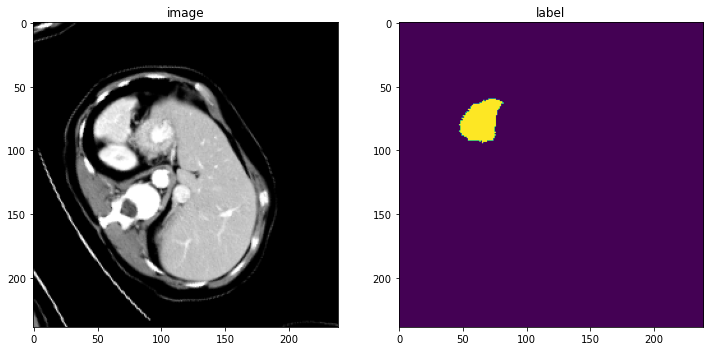

In [11]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

#### Use a dataloader to load files
    - Ability to use LMDB (Lightning Memory-Mapped Database)
    - Here is where transforms take place and they happen on both images and labels

In [12]:
train_ds = LMDBDataset(data=train_files, transform=train_transforms, cache_dir=root_dir)
# initialize cache and print meta information
print(train_ds.info())

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

# the validation data loader will be created on the fly to ensure 
# a deterministic validation set for demo purpose.
val_ds = LMDBDataset(data=val_files, transform=val_transforms, cache_dir=root_dir)
# initialize cache and print meta information
print(val_ds.info())

100%|██████████| 32/32 [00:00<00:00, 57113.93it/s]


Accessing lmdb file: /home/jupyter/covid19det-kaggle/kaggle/MonaiTesting/monai_data/monai_cache.lmdb.


100%|██████████| 32/32 [00:00<00:00, 47679.48it/s]


{'map_addr': 0, 'map_size': 1099511627776, 'last_pgno': 941102, 'last_txnid': 100, 'max_readers': 126, 'num_readers': 0, 'size': 32, 'filename': '/home/jupyter/covid19det-kaggle/kaggle/MonaiTesting/monai_data/monai_cache.lmdb'}


100%|██████████| 9/9 [00:00<00:00, 10999.05it/s]


Accessing lmdb file: /home/jupyter/covid19det-kaggle/kaggle/MonaiTesting/monai_data/monai_cache.lmdb.


100%|██████████| 9/9 [00:00<00:00, 17739.07it/s]

{'map_addr': 0, 'map_size': 1099511627776, 'last_pgno': 941102, 'last_txnid': 100, 'max_readers': 126, 'num_readers': 0, 'size': 9, 'filename': '/home/jupyter/covid19det-kaggle/kaggle/MonaiTesting/monai_data/monai_cache.lmdb'}


In [13]:
print(train_ds.info())

{'map_addr': 0, 'map_size': 1099511627776, 'last_pgno': 941102, 'last_txnid': 100, 'max_readers': 126, 'num_readers': 0, 'size': 32, 'filename': '/home/jupyter/covid19det-kaggle/kaggle/MonaiTesting/monai_data/monai_cache.lmdb'}


#### Now we want to download the pretrained model from NVIDIA

In [14]:
mmar = {
    RemoteMMARKeys.ID: "clara_pt_spleen_ct_segmentation_1",
    RemoteMMARKeys.NAME: "clara_pt_spleen_ct_segmentation",
    RemoteMMARKeys.FILE_TYPE: "zip",
    RemoteMMARKeys.HASH_TYPE: "md5",
    RemoteMMARKeys.HASH_VAL: None,
    RemoteMMARKeys.MODEL_FILE: os.path.join("models", "model.pt"),
    RemoteMMARKeys.CONFIG_FILE: os.path.join("config", "config_train.json"),
    RemoteMMARKeys.VERSION: 2,
}

In [15]:
mmar['name']

'clara_pt_spleen_ct_segmentation'

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
if PRETRAINED:
    print("using a pretrained model.")
    try: #MONAI=0.8
        unet_model = load_from_mmar(
            item = mmar['name'], 
            mmar_dir=root_dir,
            map_location=device,
            version=mmar['version'],
            pretrained=True)
    except: #MONAI<0.8
        unet_model = load_from_mmar(
            mmar, 
            mmar_dir=root_dir,
            map_location=device,
            pretrained=True)
    model = unet_model
else: 
    print("using a randomly init. model.")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    )

model = model.to(device)

using a pretrained model.
2022-04-27 14:49:45,704 - INFO - Expected md5 is None, skip md5 check for file monai_data/clara_pt_spleen_ct_segmentation_2.zip.
2022-04-27 14:49:45,705 - INFO - File exists: monai_data/clara_pt_spleen_ct_segmentation_2.zip, skipped downloading.
2022-04-27 14:49:45,706 - INFO - Non-empty folder exists in monai_data/clara_pt_spleen_ct_segmentation, skipped extracting.
2022-04-27 14:49:45,707 - INFO - 
*** "clara_pt_spleen_ct_segmentation" available at monai_data/clara_pt_spleen_ct_segmentation.
2022-04-27 14:49:49,353 - INFO - *** Model: <class 'monai.networks.nets.unet.UNet'>
2022-04-27 14:49:49,400 - INFO - *** Model params: {'dimensions': 3, 'in_channels': 1, 'out_channels': 2, 'channels': [16, 32, 64, 128, 256], 'strides': [2, 2, 2, 2], 'num_res_units': 2, 'norm': 'batch'}
2022-04-27 14:49:49,411 - INFO - 
---
2022-04-27 14:49:49,412 - INFO - For more information, please visit https://ngc.nvidia.com/catalog/models/nvidia:med:clara_pt_spleen_ct_segmentation


### This will be our test file we will view for reference
 - Here we see how our initial model appears to perform

In [17]:
test_file = data_dicts[20:21]
test_ds = LMDBDataset(data=test_file, transform=None, cache_dir=root_dir)

100%|██████████| 1/1 [00:00<00:00, 4639.72it/s]

Accessing lmdb file: /home/jupyter/covid19det-kaggle/kaggle/MonaiTesting/monai_data/monai_cache.lmdb.


#### We use a sliding window technique to search the image

In [18]:
num_classes=2
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=num_classes)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=num_classes)])
model.eval()
with torch.no_grad():
    for data in DataLoader(test_ds, batch_size=1, num_workers=2):
        test_inputs, test_labels = (
                        data["image"].to(device),
                        data["label"].to(device),
                    )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.5)
        test_outputspre = [post_pred(i) for i in decollate_batch(test_outputs)] # Decollate our results
        test_labelspre = [post_label(i) for i in decollate_batch(test_labels)]

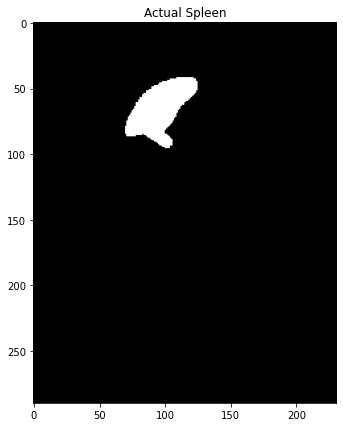

In [19]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Actual Spleen')
plt.imshow(test_labelspre[0].cpu().numpy()[1][:,:,200], cmap='Greys_r') #Actual spleen

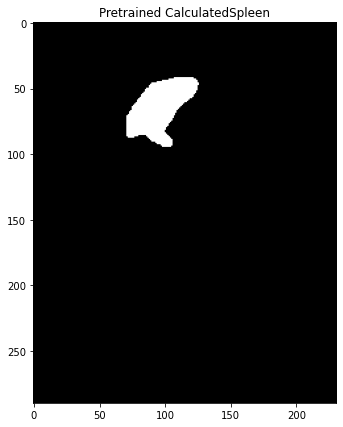

In [20]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Pretrained CalculatedSpleen')
plt.imshow(test_outputspre[0].cpu().numpy()[1][:,:,200], cmap='Greys_r') #Pretrained model spleen

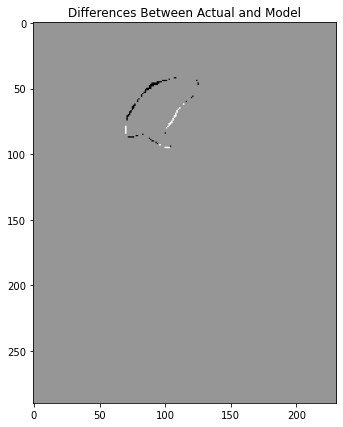

In [21]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Differences Between Actual and Model')
pretraineddif = test_labelspre[0].cpu().numpy()[1][:,:,200] - test_outputspre[0].cpu().numpy()[1][:,:,200]
plt.imshow(pretraineddif, cmap='Greys_r') #Differences

#### Using just the pretrained model, it appears we are performing pretty well
    - We can now continue to train with our data using the NVIDIA models initial weights

## Training
#### Without a GPU, training can take a while
#### Recommend skipping next three cells and load in model

In [22]:
loss_function = DiceFocalLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 5e-4)

In [23]:
max_epochs = 25
val_interval = 2
num_classes = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=num_classes)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=num_classes)])
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    set_determinism(seed=42)
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            set_determinism(seed=42)
            for val_data in DataLoader(val_ds, batch_size=1, num_workers=2):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.5)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "Spleen_best_metric_model_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/25
1/16, train_loss: 0.8680
2/16, train_loss: 0.3699
3/16, train_loss: 0.3849
4/16, train_loss: 0.1306
5/16, train_loss: 0.2781
6/16, train_loss: 0.3628
7/16, train_loss: 0.3609
8/16, train_loss: 0.1828
9/16, train_loss: 0.1493
10/16, train_loss: 0.5063
11/16, train_loss: 0.2929
12/16, train_loss: 0.2826
13/16, train_loss: 0.2017
14/16, train_loss: 0.2591
15/16, train_loss: 0.2568
16/16, train_loss: 0.2385
epoch 1 average loss: 0.3203
----------
epoch 2/25
1/16, train_loss: 0.3457
2/16, train_loss: 0.2234
3/16, train_loss: 0.3443
4/16, train_loss: 0.0816
5/16, train_loss: 0.2259
6/16, train_loss: 0.1580
7/16, train_loss: 0.2593
8/16, train_loss: 0.1651
9/16, train_loss: 0.1124
10/16, train_loss: 0.4822
11/16, train_loss: 0.2900
12/16, train_loss: 0.2571
13/16, train_loss: 0.1799
14/16, train_loss: 0.1984
15/16, train_loss: 0.2286
16/16, train_loss: 0.2216
epoch 2 average loss: 0.2359
saved new best metric model
current epoch: 2 current mean dice: 0.8615
best mean dic

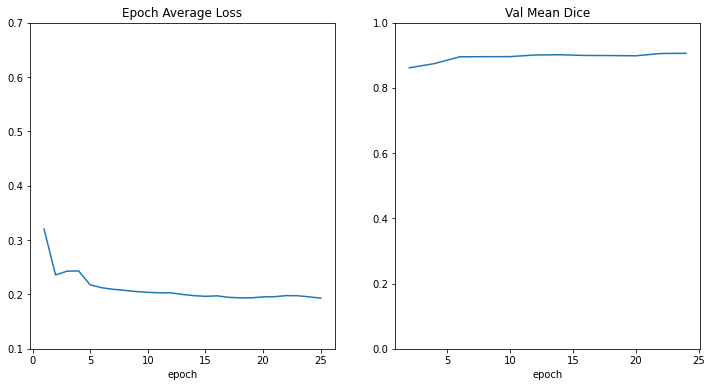

In [24]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.ylim([0.1, 0.7])
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim([0, 1.0])
plt.plot(x, y)
plt.show()

#### The model shows that it has improved fairly quickly over just 25 epochs

## Inference
#### Without GPU skip to here to load previously trained best model (without a gpu the training will take a while)

In [25]:
model.load_state_dict(torch.load('monai_data/best_metric_model_pretrained.pth'))

<All keys matched successfully>

#### With the model loaded let's see if much has changed for our example image

In [26]:
num_classes = 2
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=num_classes)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=num_classes)])
model.eval()
with torch.no_grad():
    for data in DataLoader(test_ds, batch_size=1, num_workers=2):
        test_inputs, test_labels = (
                        data["image"].to(device),
                        data["label"].to(device),
                    )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.5)
        test_outputsSpl = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labelsSpl = [post_label(i) for i in decollate_batch(test_labels)]

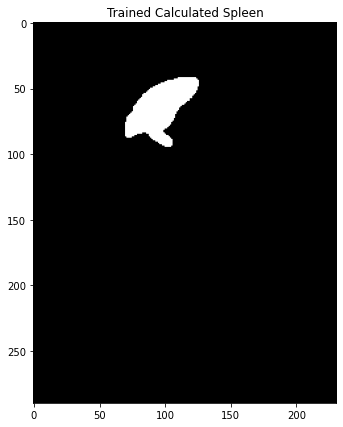

In [27]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Trained Calculated Spleen')
plt.imshow(test_outputsSpl[0].cpu().numpy()[1][:,:,200], cmap='Greys_r') #Pretrained model spleen

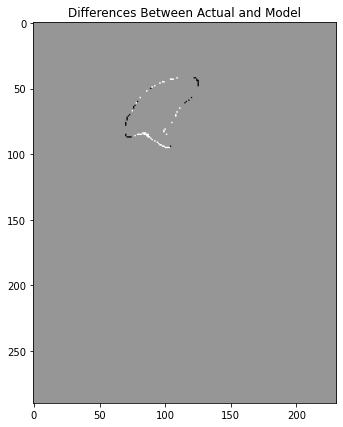

In [28]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Differences Between Actual and Model')
traineddif = test_labelsSpl[0].cpu().numpy()[1][:,:,200] - test_outputsSpl[0].cpu().numpy()[1][:,:,200]
plt.imshow(traineddif, cmap='Greys_r') #Differences

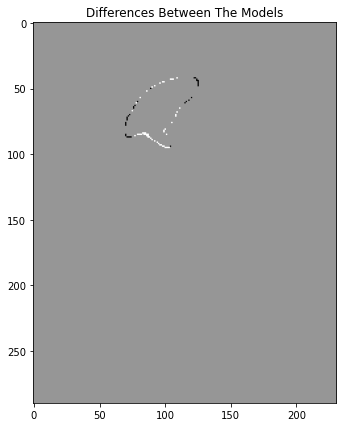

In [29]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Differences Between The Models')
modelsdif = test_outputspre[0].cpu().numpy()[1][:,:,200] - test_outputsSpl[0].cpu().numpy()[1][:,:,200]
plt.imshow(traineddif, cmap='Greys_r') #Differences

#### We see not much has changed, which is a good sign for how well the NVIDIA model performs out of the box.

#### Here is the final image of our Spleen

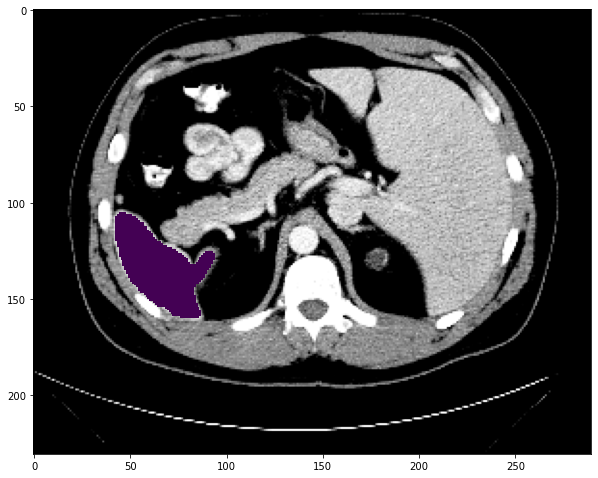

In [30]:
maskedspleen = np.ma.masked_where(test_outputsSpl[0].cpu().numpy()[1][:,:,200] == 0, test_outputsSpl[0].cpu().numpy()[1][:,:,200])
fig = plt.figure(frameon=False, figsize=(10,10))
plt.imshow(np.rot90(test_ds[0]['image'][0][:,:,200]), cmap='Greys_r')
plt.imshow(np.rot90(maskedspleen), cmap='viridis', alpha=1.0)

#### Feel free to play around in this notebook or download it and use it where a GPU is accessible

## Additional Exercise: Use liver segmentation in addition to spleen
    - Just need to load liver segmentation from NVIDIA
    - While we can't train this model, since we don't have training data, we can use it as a rough estimate

In [31]:
mmarliver = {
    RemoteMMARKeys.ID: "clara_pt_liver_and_tumor_ct_segmentation_1",
    RemoteMMARKeys.NAME: "clara_pt_liver_and_tumor_ct_segmentation",
    RemoteMMARKeys.FILE_TYPE: "zip",
    RemoteMMARKeys.HASH_TYPE: "md5",
    RemoteMMARKeys.HASH_VAL: None,
    RemoteMMARKeys.MODEL_FILE: os.path.join("models", "model.pt"),
    RemoteMMARKeys.CONFIG_FILE: os.path.join("config", "config_train.json"),
    RemoteMMARKeys.VERSION: 1,
}

In [32]:
    try: #MONAI=0.8
        unet_model = load_from_mmar(
            item = mmarliver['name'], 
            mmar_dir=root_dir,
            map_location=device,
            version=mmarliver['version'],
            pretrained=True)
    except: #MONAI<0.8
        unet_model = load_from_mmar(
            mmarliver, 
            mmar_dir=root_dir,
            map_location=device,
            pretrained=True)
    model = unet_model

2022-04-27 15:06:54,404 - INFO - Expected md5 is None, skip md5 check for file monai_data/clara_pt_liver_and_tumor_ct_segmentation_1.zip.
2022-04-27 15:06:54,405 - INFO - File exists: monai_data/clara_pt_liver_and_tumor_ct_segmentation_1.zip, skipped downloading.
2022-04-27 15:06:54,425 - INFO - Non-empty folder exists in monai_data/clara_pt_liver_and_tumor_ct_segmentation, skipped extracting.
2022-04-27 15:06:54,426 - INFO - 
*** "clara_pt_liver_and_tumor_ct_segmentation" available at monai_data/clara_pt_liver_and_tumor_ct_segmentation.
2022-04-27 15:06:54,889 - INFO - *** Model: <class 'monai.networks.nets.unet.UNet'>
2022-04-27 15:06:54,938 - INFO - *** Model params: {'dimensions': 3, 'in_channels': 1, 'out_channels': 3, 'channels': [16, 32, 64, 128, 256], 'strides': [2, 2, 2, 2], 'num_res_units': 2, 'norm': 'batch'}
2022-04-27 15:06:54,950 - INFO - 
---
2022-04-27 15:06:54,951 - INFO - For more information, please visit https://ngc.nvidia.com/catalog/models/nvidia:med:clara_pt_live

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("using a pretrained model.")
try: #MONAI=0.8
    unet_model = load_from_mmar(
        item = mmarliver['name'], 
        mmar_dir=root_dir,
        map_location=device,
        version=mmarliver['version'],
        pretrained=True)
except: #MONAI<0.8
    unet_model = load_from_mmar(
        mmarliver, 
        mmar_dir=root_dir,
        map_location=device,
        pretrained=True)
model = unet_model.to(device)

using a pretrained model.
2022-04-27 15:06:55,931 - INFO - Expected md5 is None, skip md5 check for file monai_data/clara_pt_liver_and_tumor_ct_segmentation_1.zip.
2022-04-27 15:06:55,931 - INFO - File exists: monai_data/clara_pt_liver_and_tumor_ct_segmentation_1.zip, skipped downloading.
2022-04-27 15:06:55,932 - INFO - Non-empty folder exists in monai_data/clara_pt_liver_and_tumor_ct_segmentation, skipped extracting.
2022-04-27 15:06:55,933 - INFO - 
*** "clara_pt_liver_and_tumor_ct_segmentation" available at monai_data/clara_pt_liver_and_tumor_ct_segmentation.
2022-04-27 15:06:55,962 - INFO - *** Model: <class 'monai.networks.nets.unet.UNet'>
2022-04-27 15:06:56,010 - INFO - *** Model params: {'dimensions': 3, 'in_channels': 1, 'out_channels': 3, 'channels': [16, 32, 64, 128, 256], 'strides': [2, 2, 2, 2], 'num_res_units': 2, 'norm': 'batch'}
2022-04-27 15:06:56,023 - INFO - 
---
2022-04-27 15:06:56,024 - INFO - For more information, please visit https://ngc.nvidia.com/catalog/model

In [34]:
num_classesP=3
num_classesL=2
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=num_classesP)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=num_classesL)])
model.eval()
with torch.no_grad():
    for data in DataLoader(test_ds, batch_size=1, num_workers=2):
        test_inputs, test_labels = (
                        data["image"].to(device),
                        data["label"].to(device),
                    )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.5)
        test_outputsliv = [post_pred(i) for i in decollate_batch(test_outputs)] # Decollate our results
        test_labelsliv = [post_label(i) for i in decollate_batch(test_labels)]

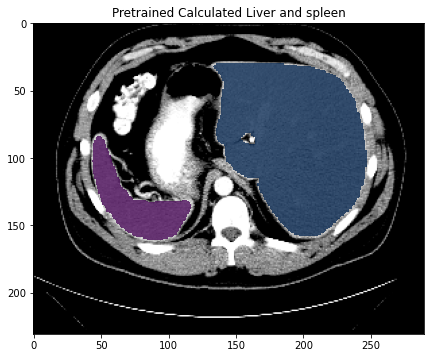

In [35]:
sliceval = 215
maskedliv = np.ma.masked_where(test_outputsliv[0].cpu().numpy()[1][:,:,sliceval] == 0, test_outputsliv[0].cpu().numpy()[1][:,:,sliceval])
maskedspleen = np.ma.masked_where(test_outputsSpl[0].cpu().numpy()[1][:,:,sliceval] == 0, test_outputsSpl[0].cpu().numpy()[1][:,:,sliceval])
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Pretrained Calculated Liver and spleen')
plt.imshow(np.rot90(test_ds[0]['image'][0][:,:,sliceval]), cmap='Greys_r')
plt.imshow(np.rot90(maskedliv), cmap='cividis', alpha=0.75)
plt.imshow(np.rot90(maskedspleen), cmap='viridis', alpha=0.75)

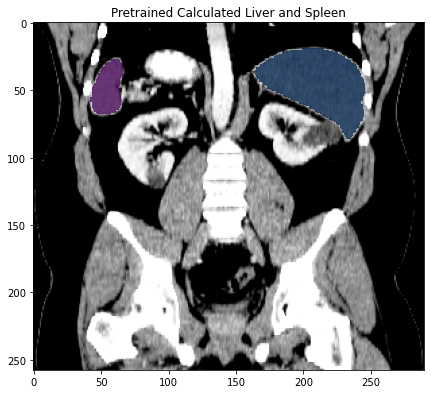

In [36]:
sliceval = 110
maskedliv = np.ma.masked_where(test_outputsliv[0].cpu().numpy()[1][:,sliceval,:] == 0, test_outputsliv[0].cpu().numpy()[1][:,sliceval,:])
maskedspleen = np.ma.masked_where(test_outputsSpl[0].cpu().numpy()[1][:,sliceval,:] == 0, test_outputsSpl[0].cpu().numpy()[1][:,sliceval,:])
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Pretrained Calculated Liver and Spleen')
plt.imshow(np.rot90(test_ds[0]['image'][0][:,sliceval,:]), cmap='Greys_r')
plt.imshow(np.rot90(maskedliv), cmap='cividis', alpha=0.75)
plt.imshow(np.rot90(maskedspleen), cmap='viridis', alpha=0.75)

#### Continue including more models found at the NGC Catalog: 
#### https://catalog.ngc.nvidia.com/models
##### - Recommend filtering by 'CT' 